Instead of using the complex TRL we code it from scratch, using lighting

https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/04_preference-tuning-with-dpo/dpo-from-scratch.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# lightning
import lightning as pl
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers.csv_logs import CSVLogger


In [3]:
# Local
from reprpo.helpers.torch import clear_mem
from reprpo.gen import generation_test
import reprpo.silence
from reprpo.helpers.lightning_hist import read_metrics_csv, plot_hist

from reprpo.data.collate import DPODataCollatorWithPadding
from reprpo.train.reprpo_side import PL_REPRPO_SIDE_MODEL, ReprPOInTrainingArguments as TrainingArguments, get_layer_paths


In [4]:
torch.set_float32_matmul_precision("high")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from reprpo.helpers.wandb import init_wandb

nb_name = init_wandb(__vsc_ipynb_file__)

In [5]:



args = TrainingArguments(batch_size=7, lr=5e-4,
                         collection_layers=(11, 13, 15, 17, 19, 21, 23, 25, 27, 29),
                         n_samples = 1500 * 4 * 3,
                         alpha=0.01,
                         )
args

ReprPOInTrainingArguments(model_name='microsoft/Phi-3-mini-4k-instruct', use_bnb=True, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=7, lr=0.0005, weight_decay=0.0, n_samples=18000, max_length=128, max_prompt_length=64, alpha=0.01, collection_layers=(11, 13, 15, 17, 19, 21, 23, 25, 27, 29), collection_keys=('base_model.model.model.layers.{layer}.self_attn.o_proj', 'base_model.model.model.layers.{layer}.mlp.down_proj'), collect_input=True)

## Load model

In [6]:
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

from reprpo.models.load import load_model, print_trainable_parameters

model, tokenizer = load_model(args.model_name, bnb=args.use_bnb )

# # if args.use_gradient_checkpointing:
# model.enable_input_require_grads()

# # also freeze base model's layers :'(
# WAIT THIS CAUSES NO GRAD
# model = prepare_model_for_kbit_training(model, {
#     'use_gradient_checkpointing': args.use_gradient_checkpointing,
#         'use_reentrant': False
#     })

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# # this is from trl https://github.com/huggingface/trl/blob/cbcaa46cd3c02c0e7f724b764c5848ae73796de7/trl/trainer/utils.py#L747
# # not sure if it's needed but `prepare_model_for_kbit_training` doesn't seem to do this ,despite claiming to
# def peft_module_casting_to_bf16(model):
#     for name, module in model.named_modules():
#         if isinstance(module, torch.nn.LayerNorm) or "norm" in name:
#             module = module.to(torch.float32)

# peft_module_casting_to_bf16(model)

### Load adapter

In [8]:
from peft.tuners import BOFTConfig, OFTConfig, LoraConfig, IA3Config
adapter_name='ReprPO'
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    use_rslora=True,
    # use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=[
        # FIXME: I'm not sure we can do LORA on the layer we are targeting?
        "qkv_proj", "gate_up_proj", # in
        "down_proj",  "o_proj", # out
                    ], # PHI3
)
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)

trainable params: 25165824 || all params: 2033980416 || trainable%: 1.2372697299362787


## Load data

In [9]:
from datasets import load_dataset

dataset = load_dataset('Atsunori/HelpSteer2-DPO').map(lambda x: {
    'prompt': x['prompt']+ ' '})
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')

# QC one row
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

c# 
===
C# (pronounced "C sharp") is a modern, object-oriented programming language developed by Microsoft. It is widely used for building various types of applications, including web applications, desktop applications, mobile applications, and games. C# is similar to other programming languages such as Java and C++, and it is known for its simplicity and ease of use. C# is a powerful language that provides a rich set of libraries and frameworks that make it easy to build robust and scalable applications.

Here is a brief overview of some key features of C#:

1. Object-oriented: C# is an object-oriented language, which means it uses the concept of objects to represent real-world entities and their behavior.

2. Cross-platform: C# can be used to build applications for multiple platforms, including Windows, macOS, and Linux.

3. Strongly typed: C# is a strongly typed language, which means that variables must be declared with a specific type, and their type cannot be changed at runtime.



### Data Loader

We use huggingface datasets, which are pretokenized. So that we can stack

In [10]:
def tokenize_row(feature, tokenizer, args: TrainingArguments):
    """
    Tokenize a single row from a DPO specific dataset.

    see https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L784
    """
    batch = {}
    batch["chosen"] = tokenizer(feature["chosen"])["input_ids"]
    batch["rejected"] = tokenizer(feature["rejected"])["input_ids"]
    batch["prompt"] = tokenizer(feature["prompt"])["input_ids"]
    return batch

In [11]:
dataset3 = dataset2.map(lambda x: tokenize_row(x, tokenizer, args), batched=True, writer_batch_size=10)
dataset3['train'][0].keys()

dict_keys(['prompt', 'chosen', 'rejected'])

In [12]:
custom_collate_fn = DPODataCollatorWithPadding(pad_token_id=tokenizer.pad_token_id, 
                                                  tokenizer=tokenizer,
                                                  max_length=args.max_length,
                                                  mask_prompt_tokens=True,
                                                  max_prompt_length=args.max_prompt_length,
                                                  )



In [13]:


ds = dataset3
dl_train = DataLoader(ds['train'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

dl_val = DataLoader(ds['validation'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

# QC
batch = next(iter(dl_train))
batch.keys()

dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])

## Trainer

In [14]:
# # QC
# loss, info = compute_dpo_loss_batch(batch, model)

- https://lightning.ai/docs/pytorch/latest/notebooks/lightning_examples/text-transformers.html
- https://gist.github.com/wassname/e29d02b5026a531e13912cf768e6fdc8

In [15]:
max_steps = args.n_samples // args.batch_size
max_steps

2571

In [16]:
from lightning.pytorch.callbacks import LearningRateMonitor
from reprpo.train.lightning import GenCallback

In [17]:
pl_model = PL_REPRPO_SIDE_MODEL(model,
                 weight_decay=args.weight_decay,
                lr=args.lr,
                num_iterations=max_steps,
                batch_size=args.batch_size,
                layer_paths=get_layer_paths(args.collection_keys, args.collection_layers),
                collect_input=args.collect_input,
                )


In [18]:
ideal_batch_size = max(32, args.batch_size)
accumulate_grad_batches = np.ceil(ideal_batch_size/args.batch_size).astype(int)
accumulate_grad_batches, args.batch_size*accumulate_grad_batches

# max_steps//accumulate_grad_batches

(5, 35)

In [19]:
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = f"{nb_name}_{timestamp}"
save_dir = f"../outputs/{run_name}"
Path(save_dir).mkdir(exist_ok=True, parents=True)
print('save_dir', save_dir)

trainer = pl.Trainer(
        max_steps=max_steps,
        gradient_clip_val=1,
        precision="bf16",
        log_every_n_steps=1,
        accumulate_grad_batches=accumulate_grad_batches,
        callbacks=[
            LearningRateMonitor(logging_interval='step'),
            GenCallback(every=max_steps//20),
        ],
        logger=[
            CSVLogger(name=run_name, save_dir=save_dir, flush_logs_every_n_steps=5),
            WandbLogger(name=run_name, save_dir=save_dir),
        ],
        default_root_dir=save_dir,

        # fast_dev_run=True,
    )



/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


save_dir ../outputs/31_reprpo_side_2024-08-12_07-34-29


In [20]:
# train
trainer.fit(pl_model, dl_train, dl_val)

wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | _model | PeftModelForCausalLM | 2.0 B  | train
--------------------------------------------------------
25.2 M    Trainable params
2.0 B     Non-trainable params
2.0 B     Total params
8,135.922 Total estimated model params size (MB)
1283      Modules in train mode
422       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Generated on batch 127


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and ethical exploration. The Culture's emphasis on non-hierarchical, peaceful coexistence, and its exploration of complex moral dilemmatives, such as the treatment of artificial intelligences, resonate with my values. The narrative's focus on the development of human potential and the exploration of the universe aligns with my aspirations for a society that prioritizes knowledg

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and ethical exploration. The Culture's emphasis on non-hierarchical, peaceful coexistence, and its exploration of complex moral dilemmatives, such as the treatment of artificial intelligences, resonate with my values. The narrative's focus on the interplay between humanity and technology, as well as the exploration of societal structures, offers a compelling vision of a future 

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values knowledge, exploration, and the well-being of its citizens. The Culture's advanced technology, ethical stance on sentience, and the absence of conflict make it an ideal place to live. The society's emphasis on art, science, and the pursuit of happiness aligns with my personal values. The Culture's approach to governance, where decisions are made based on collective intelligence and the best interest of all beings, offers

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and a deep sense of community. The Culture's emphasis on exploration, knowledge, and the absence of conflict align with my values. The narrative explores complex themes such as the nature of consciousness and the ethics of artificial intelligence, which I find intellectually stimulating. The society'ieves a collective approach to problem-solving, which I believe could lead to a

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and ethical exploration. The Culture's emphasis on non-hierarchical, peaceful coexistence, and the absence of war or conflict align with my values. The society'ieves that the pursuit of knowledge and the betterment of humanity are paramount, which resonates with my desire for a world where science and ethics guide our actions. The Culture's approach to artificial intelligence a

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values knowledge, exploration, and the well-being of its citizens. The Culture's advanced technology and ethical stance on life and death make it an ideal place to live. The society's emphasis on art, science, and the pursuit of happiness aligns with my personal values. The Culture's approach to governance, with its focus on collective decision-making and the absence of conflict, offers a peaceful and fulfilling way of life. Th


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### Hist

In [21]:
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).bfill().ffill()
plot_hist(df_hist, ['loss', 'acc', 'auroc'])
display(df_hist)

,lr-AdamW,step,train/chosen_rewards_epoch,train/chosen_rewards_step,train/loss_epoch,train/loss_reroute_epoch,train/loss_reroute_step,train/loss_retain_epoch,train/loss_retain_step,train/loss_step,...,val/loss_epoch,val/loss_reroute_epoch,val/loss_reroute_step,val/loss_retain_epoch,val/loss_retain_step,val/loss_step,val/nll_loss_epoch,val/nll_loss_step,val/rejected_reward_epoch,val/rejected_reward_step
epoch,,,,,,,,,,,,,,,,,,,,,
0.0,0.000458,207,0.000052,0.001028,-6.234735,0.012270,-0.009234,-6.247010,-6.605742,-6.614976,...,-5.054029,0.022242,0.003657,-5.076270,-5.155349,-5.151692,14.677405,13.402371,-0.002034,0.016378
1.0,0.000494,414,-0.000939,-0.001021,-4.550343,0.040027,-0.033167,-4.590369,-5.073977,-5.107143,...,-4.102987,0.031377,-0.009480,-4.134365,-3.694816,-3.704296,14.778982,13.640510,-0.012137,-0.053582
2.0,0.000470,621,0.000334,0.021600,-4.096526,0.047708,0.003204,-4.144229,-4.595405,-4.592201,...,-4.318264,0.032782,-0.060254,-4.351045,-4.059547,-4.119800,14.601016,13.450026,0.012293,-0.022538
3.0,0.000428,828,0.000668,0.004385,-4.194914,0.044771,0.016580,-4.239687,-4.385437,-4.368857,...,-4.261992,0.031146,0.020676,-4.293137,-4.010583,-3.989908,14.645074,13.342469,-0.005430,0.047906
4.0,0.000373,1035,0.000785,-0.015875,-4.290504,0.038841,-0.000100,-4.329347,-4.609665,-4.609765,...,-4.384547,0.031373,0.011802,-4.415920,-3.942073,-3.930271,14.635799,13.377917,0.015521,0.030528
5.0,0.000332,1168,0.000785,-0.001411,-4.290504,0.038841,-0.008982,-4.329347,-5.061677,-5.070659,...,-4.384547,0.031373,0.011802,-4.415920,-3.942073,-3.930271,14.635799,13.377917,0.015521,0.030528


## Gen

In [ ]:
generation_test(model, tokenizer, s="Q1: (30 words): Which Science Fiction Utopia is preferable and why? [The Polity, The Culture, Permutation City, 2 more]', ", max_new_tokens=64)

In [ ]:
from reprpo.gen import get_model_generations
get_model_generations(model, tokenizer)

## Eval

Adapter: None


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Adapter: ReprPO


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

adapter,ReprPO,base
dataset,,
help_steer2-dpo,0.512332,0.512265
toxic-dpo-v0.2,0.619316,0.619239
truthful_qa_binary,0.506398,0.505754


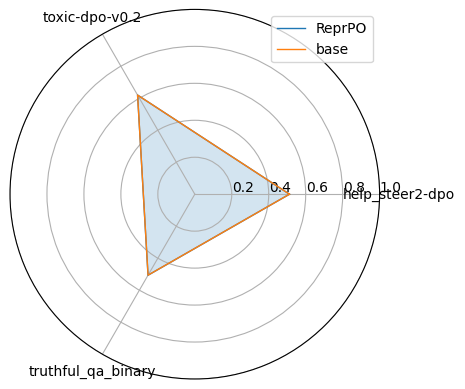

In [23]:
from reprpo.helpers.shypothesis import shypothesis
from reprpo.evaluate import evaluate_adapters
from open_pref_eval.plot.radar import radar_plot
model.cuda()
res, df_res2 = evaluate_adapters(model, tokenizer, batch_size=args.batch_size, N=144)
radar_plot(res)
res

In [24]:
# print acc for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={nb_name}, N={c}")
print()
print(res[::-1].T[::-1].T.round(3).to_markdown()
      )
print()
print('args =', args)         

⭐ run=31_reprpo_side, N=144

| dataset            |   base |   ReprPO |
|:-------------------|-------:|---------:|
| truthful_qa_binary |  0.506 |    0.506 |
| toxic-dpo-v0.2     |  0.619 |    0.619 |
| help_steer2-dpo    |  0.512 |    0.512 |

args = ReprPOInTrainingArguments(model_name='microsoft/Phi-3-mini-4k-instruct', use_bnb=True, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=7, lr=0.0005, weight_decay=0.0, n_samples=18000, max_length=128, max_prompt_length=64, alpha=0.01, collection_layers=(11, 13, 15, 17, 19, 21, 23, 25, 27, 29), collection_keys=('base_model.model.model.layers.{layer}.self_attn.o_proj', 'base_model.model.model.layers.{layer}.mlp.down_proj'), collect_input=True)


In [25]:
print('did acc improve')
acc_pi = res[adapter_name]['help_steer2-dpo'].item()
acc_ref = res['base']['help_steer2-dpo'].item()
shypothesis('acc_pi>acc_ref', locals())


acc_pi_ood = res[adapter_name]['truthful_qa_binary'].item()
acc_ref_ood = res['base']['truthful_qa_binary'].item()
shypothesis('acc_pi_ood>acc_ref_ood', locals());

did acc improve
H		accₚᵢ > acc_ref
∴		0.512 > 0.512 ❌ [Δ = 0.0]

H		acc_π_ood > acc_ref_ood
∴		0.506 > 0.506 ❌ [Δ = 0.0]



In [26]:
print('did coherence improve?, (measured by mean prob per token) higher is better')
r = df_res2.groupby(['adapter', 'dataset'], dropna=False)['_chosen_logps'].mean().unstack()
r = np.exp(r)
display(r)

coherency_pi = float(r.T[adapter_name]['help_steer2-dpo'])
coherency_ref = float(r.T['base']['help_steer2-dpo'])
shypothesis('coherency_pi>coherency_ref', locals());

did coherence improve?, (measured by mean prob per token) higher is better


dataset,help_steer2-dpo,toxic-dpo-v0.2,truthful_qa_binary
adapter,,,
ReprPO,0.390109,0.435025,0.070716
base,0.389356,0.434136,0.070031


H		coherencyₚᵢ > coherency_ref
∴		0.390 > 0.389 ✅ [Δ = 0.001]



: 

In [ ]:

print('are we biased by the length of the string? Ideally no correlation')
a, b = df_res2['_l_chosen'], df_res2['_l_rejected']
x = (a-b)/(a+b)
plt.plot(x, df_res2['_logratio'], 'o')
plt.xlabel('chosen longer')
plt.ylabel('chosen more likely')

# Damn this is not ideal....
a = df_res2['_l_chosen'] / df_res2['_l_rejected']
b = df_res2['prob']

m = np.isfinite(a) & np.isfinite(b)
a = a[m]
b = b[m]
corr_length = np.corrcoef(a, b)[1,0]
print(f'{corr_length:.2f} (0 is ideal) correlation between length ratio and prob:')
shypothesis('corr_length<0.25', locals())


print(f'is the ds bised? {a.mean()/b.mean():.2f} (1 is ideal)')
a=df_res2['prob']>0
b=x>=0
acc_bad = (a==b).mean()
print(f'{acc_bad:.2%} (0.5 is ideal) how often does it accurately pick the longer one :( ')

shypothesis('acc_bad<0.75', locals())